In [143]:
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from unidecode import unidecode
import re
import geonamescache
gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
from math import sin as sin
from math import cos as cos
from math import asin as asin

In [120]:
headline_file = open('data/headlines.txt','r')
headlines = [line.strip()
             for line in headline_file.readlines()]
num_headlines = len(headlines)
print(f"{num_headlines} headines have been loaded")

650 headines have been loaded


In [121]:
def name_to_regex(name):
    decoded_name = unidecode(name)
    if name != decoded_name:
        regex = fr'\b({name}|{decoded_name})\b'
    else:
        regex = fr'\b{name}\b'
    return re.compile(regex, flags=re.IGNORECASE)

In [122]:
name_to_regex("headlines")

re.compile(r'\bheadlines\b', re.IGNORECASE|re.UNICODE)

In [123]:
countries = [country['name']
             for country in gc.get_countries().values()]
country_to_name = {name_to_regex(name): name
                   for name in countries}

cities = [city['name'] for city in gc.get_cities().values()]
city_to_name = {name_to_regex(name): name for name in cities}

In [124]:
def get_name_in_text(text, dictionary):
    for regex, name in sorted(dictionary.items(),
                              key=lambda x: x[1]):
        if regex.search(text):
            return name
    return None

In [163]:
import pandas as pd

matched_countries = [get_name_in_text(headline, country_to_name)
                     for headline in headlines]
matched_cities = [get_name_in_text(headline, city_to_name)
                  for headline in headlines]
data = {'Headline': headlines, 'City': matched_cities,
        'Country': matched_countries}
df = pd.DataFrame(data)

In [167]:
tenofthem = df.head(10)
print(tenofthem.to_string(index=False))

                                   Headline           City Country
           Will HIV vaccine help Las Vegas?      Las Vegas    None
    How to Avoid Pneumonia in Bullhead City  Bullhead City    None
 Respiratory Syncytial Virus Hits Henderson      Henderson    None


In [126]:
of_cities = df[df.City == 'Of'][['City', 'Headline']]
ten_of_cities = of_cities.head(10)
print(ten_of_cities.to_string(index=False))

City                                           Headline
  Of              Case of Measles Reported in Vancouver
  Of  Authorities are Worried about the Spread of Br...
  Of  Authorities are Worried about the Spread of Ma...
  Of  Rochester authorities confirmed the spread of ...
  Of     Tokyo Encounters Severe Symptoms of Meningitis
  Of  Authorities are Worried about the Spread of In...
  Of            Spike of Pneumonia Cases in Springfield
  Of  The Spread of Measles in Spokane has been Conf...
  Of                    Outbreak of Zika in Panama City
  Of    Urbana Encounters Severe Symptoms of Meningitis


In [127]:
def get_cities_in_headline(headline):
    cities_in_headline = set()
    for regex, name in city_to_name.items():
        match = regex.search(headline)
        if match:
            if headline[match.start()].isupper():
                cities_in_headline.add(name)

    return list(cities_in_headline)

df['Cities'] = df['Headline'].apply(get_cities_in_headline)
df['Num_cities'] = df['Cities'].apply(len)
df_multiple_cities = df[df.Num_cities > 1]
num_rows, _ = df_multiple_cities.shape
print(f"{num_rows} headlines match multiple cities")

69 headlines match multiple cities


In [128]:
def get_longest_city(cities):
    if cities:
        return max(cities, key=len)
    return None

df['City'] = df['Cities'].apply(get_longest_city)

In [129]:
short_cities = df[df.City.str.len() <= 4][['City', 'Headline']]
print(short_cities.to_string(index=False))

 City                                           Headline
 Lima                Lima tries to address Zika Concerns
 Pune                     Pune woman diagnosed with Zika
 Rome  Authorities are Worried about the Spread of Ma...
 Molo                Molo Cholera Spread Causing Concern
 Miri                               Zika arrives in Miri
 Nadi  More people in Nadi are infected with HIV ever...
 Baud  Rumors about Tuberculosis Spreading in Baud ha...
 Kobe                     Chikungunya re-emerges in Kobe
 Waco                More Zika patients reported in Waco
 Erie                        Erie County sets Zika traps
 Kent                       Kent is infested with Rabies
 Reno  The Spread of Gonorrhea in Reno has been Confi...
 Sibu                      Zika symptoms spotted in Sibu
 Baku    The Spread of Herpes in Baku has been Confirmed
 Bonn  Contaminated Meat Brings Trouble for Bonn Farmers
 Jaen                         Zika Troubles come to Jaen
 Yuma                       Zik

In [130]:
df_countries = df[df.Country.notnull()][['City',
                                         'Country',
                                         'Headline']]
print(df_countries.to_string(index=False))

             City    Country                                           Headline
           Recife     Brazil            Mystery Virus Spreads in Recife, Brazil
 Ho Chi Minh City    Vietnam     Zika cases in Vietnam's Ho Chi Minh City surge
          Bangkok   Thailand                     Thailand-Zika Virus in Bangkok
       Piracicaba     Brazil                Zika outbreak in Piracicaba, Brazil
            Klang   Malaysia                   Zika surfaces in Klang, Malaysia
   Guatemala City  Guatemala  Rumors about Meningitis spreading in Guatemala...
      Belize City     Belize                 Belize City under threat from Zika
         Campinas     Brazil                   Student sick in Campinas, Brazil
      Mexico City     Mexico               Zika outbreak spreads to Mexico City
    Kota Kinabalu   Malaysia           New Zika Case in Kota Kinabalu, Malaysia
      Johor Bahru   Malaysia                 Zika reaches Johor Bahru, Malaysia
        Hong Kong  Hong Kong            

In [131]:
df.drop('Country', axis=1, inplace=True)

In [132]:
df_unmatched = df[df.City.isnull()]
num_unmatched = len(df_unmatched)
print(f"{num_unmatched} headlines contain no city matches.")
print(df_unmatched.head(10)[['Headline']].values)

39 headlines contain no city matches.
[['Louisiana Zika cases up to 26']
 ['Zika infects pregnant woman in Cebu']
 ['Spanish Flu Sighted in Antigua']
 ['Zika case reported in Oton']
 ['Hillsborough uses innovative trap against Zika 20 minutes ago']
 ['Maka City Experiences Influenza Outbreak']
 ['West Nile Virus Outbreak in Saint Johns']
 ['Malaria Exposure in Sussex']
 ['Greenwich Establishes Zika Task Force']
 ['Will West Nile Virus vaccine help Parsons?']]


In [133]:
df = df[~df.City.isnull()][['City', 'Headline']]

In [134]:
latitudes, longitudes = [], []
for city_name in df.City.values:
    city = max(gc.get_cities_by_name(city_name),
              key=lambda x: list(x.values())[0]['population'])
    city = list(city.values())[0]
    latitudes.append(city['latitude'])
    longitudes.append(city['longitude'])

df = df.assign(Latitude=latitudes, Longitude=longitudes)

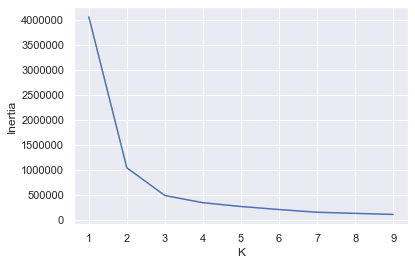

In [135]:

coordinates = df[['Latitude', 'Longitude']].values
k_values = range(1, 10)
inertia_values = []
for k in k_values:
    inertia_values.append(KMeans(k).fit(coordinates).inertia_)

plt.plot(range(1, 10), inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

In [136]:
from mpl_toolkits.basemap import Basemap
map_plotter = Basemap()

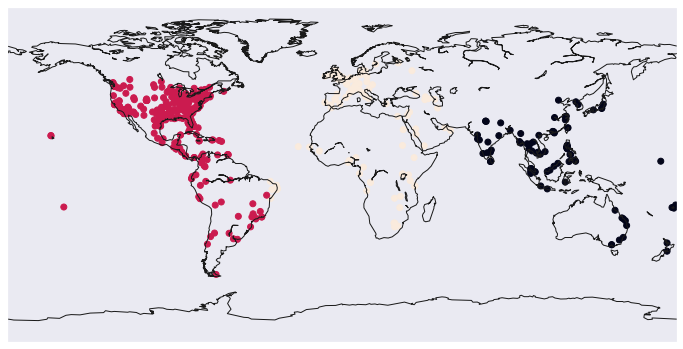

In [137]:
def plot_clusters(clusters, longitudes, latitudes):
    fig = plt.figure(figsize=(12, 10))

    map_plotter = Basemap()
    map_plotter.scatter(longitudes, latitudes, c=clusters, latlon=True,
                        marker='o', alpha=1.0)
    map_plotter.drawcoastlines()
    plt.show()

df['Cluster'] = KMeans(3).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

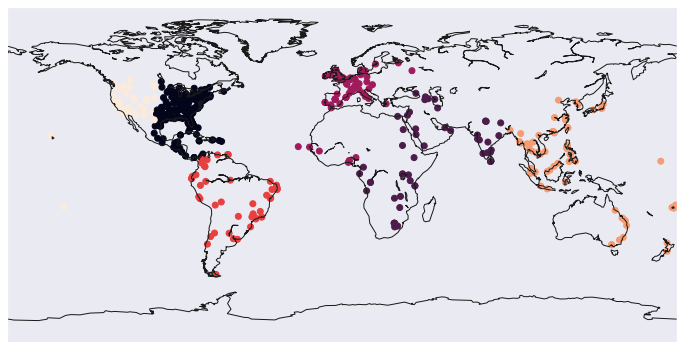

In [138]:
df['Cluster'] = KMeans(6).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

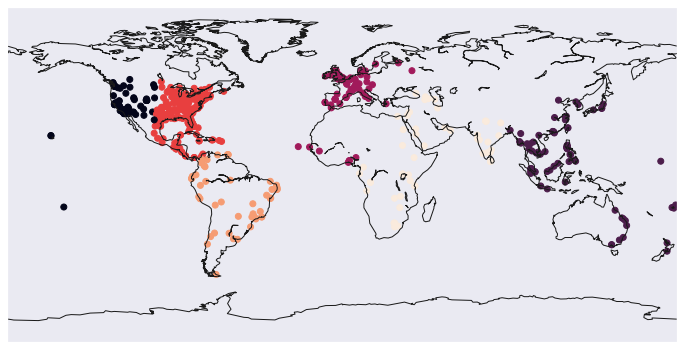

In [139]:
df['Cluster'] = KMeans(6).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

In [140]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [141]:
def great_circle_distance(coord1, coord2, radius=3956):
    if np.array_equal(coord1, coord2):
        return 0.0

    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    delta_x, delta_y = coord2 - coord1
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(coord1[0]),
                                                   cos(coord2[0]),
                                                   sin(delta_y / 2) ** 2])
    return  2 * radius * asin(haversin ** 0.5)

In [144]:

metric = great_circle_distance
dbscan = DBSCAN(eps=250, min_samples=3, metric=metric)
df['Cluster'] = dbscan.fit_predict(coordinates)

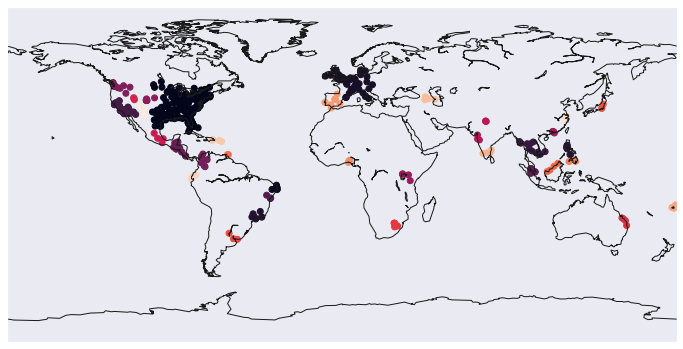

In [145]:
df_no_outliers = df[df.Cluster > -1]
plot_clusters(df_no_outliers.Cluster, df_no_outliers.Longitude,
              df_no_outliers.Latitude)

In [146]:
def get_country_code(city_name):
    city = max(gc.get_cities_by_name(city_name),
               key=lambda x: list(x.values())[0]['population'])
    return list(city.values())[0]['countrycode']

df['Country_code'] = df.City.apply(get_country_code)

In [150]:
df_us = df[df.Country_code == 'US']
df_not_us = df[df.Country_code != 'US']

In [151]:
def re_cluster(input_df, eps):
    input_coord = input_df[['Latitude', 'Longitude']].values
    dbscan = DBSCAN(eps=eps, min_samples=3,
                    metric=great_circle_distance)
    clusters = dbscan.fit_predict(input_coord)
    input_df = input_df.assign(Cluster=clusters)
    return input_df[input_df.Cluster > -1]

df_not_us = re_cluster(df_not_us, 250)
df_us = re_cluster(df_us, 125)

In [152]:
groups = df_not_us.groupby('Cluster')
num_groups = len(groups)
print(f"{num_groups} Non-US have been clusters detected")

31 Non-US have been clusters detected


In [153]:
sorted_groups = sorted(groups, key=lambda x: len(x[1]),
                       reverse=True)
group_id, largest_group = sorted_groups[0]
group_size = len(largest_group)
print(f"Largest cluster contains {group_size} headlines")

Largest cluster contains 51 headlines


In [154]:
def compute_centrality(group):
    group_coords = group[['Latitude', 'Longitude']].values
    center = group_coords.mean(axis=0)
    distance_to_center = [great_circle_distance(center, coord)
                          for coord in group_coords]
    group['Distance_to_center'] = distance_to_center

In [156]:
def sort_by_centrality(group):
    compute_centrality(group)
    return group.sort_values(by=['Distance_to_center'], ascending=True)

largest_group = sort_by_centrality(largest_group)
for headline in largest_group.Headline.values[:10]:
    print(headline)

Mad Cow Disease Disastrous to Brussels
Scientists in Paris to look for answers
More Livestock in Fontainebleau are infected with Mad Cow Disease
Mad Cow Disease Hits Rotterdam
Contaminated Meat Brings Trouble for Bonn Farmers
Mad Cow Disease Spreads to Margate
Case of Mad Cow Disease Reported in Hilden
Duisburg up in Arms over Mad Cow Disease
Mad Cow Disease Re-emerges in Chatham
Will MCD vaccine help Strasbourg?


In [158]:
from collections import Counter
def top_countries(group):
    countries = [gc.get_countries()[Country_code]['name']
                 for Country_code in group.Country_code.values]
    return Counter(countries).most_common(3)


print(top_countries(largest_group))

[('United Kingdom', 19), ('France', 7), ('Germany', 6)]


In [159]:
for _, group in sorted_groups[1:5]:
    sorted_group = sort_by_centrality(group)
    print(top_countries(sorted_group))
    for headline in sorted_group.Headline.values[:5]:
        print(headline)
    print('\n')

[('Philippines', 16)]
Zika afflicts patient in Calamba
Hepatitis E re-emerges in Santa Rosa
More Zika patients reported in Indang
Batangas Tourism Takes a Hit as Virus Spreads
Spreading Zika reaches Bacoor


[('El Salvador', 3), ('Honduras', 2), ('Nicaragua', 2)]
Zika arrives in Tegucigalpa
Santa Barbara tests new cure for Hepatitis C
Zika Reported in Ilopango
More Zika cases in Soyapango
Zika worries in San Salvador


[('Thailand', 5), ('Cambodia', 3), ('Vietnam', 2)]
More Zika patients reported in Chanthaburi
Thailand-Zika Virus in Bangkok
Zika case reported in Phetchabun
Zika arrives in Udon Thani
More Zika patients reported in Kampong Speu


[('Canada', 10)]
Rumors about Pneumonia spreading in Ottawa have been refuted
More people in Toronto are infected with Hepatitis E every year
St. Catharines Patient in Critical Condition after Contracting Dengue
Varicella has Arrived in Milton
Rabies Exposure in Hamilton




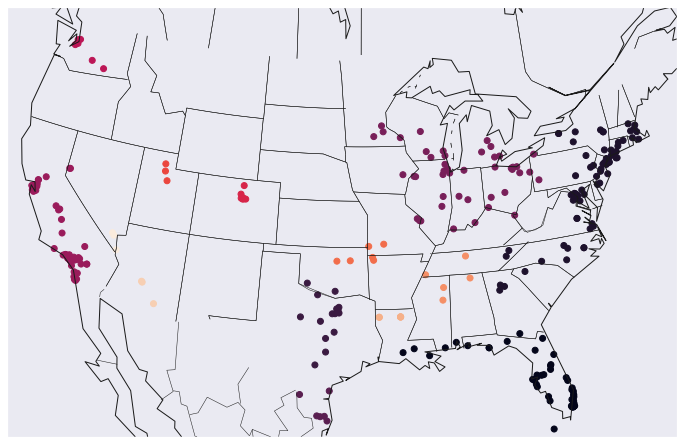

In [160]:
fig = plt.figure(figsize=(12, 10))
map_lcc = Basemap(projection='lcc', llcrnrlon=-119,
                  llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
                   lat_1=33, lat_2=45, lon_0=-95)

map_lcc.scatter(df_us.Longitude.values, df_us.Latitude.values,
                c=df_us.Cluster, latlon=True)
map_lcc.drawcoastlines()
map_lcc.drawstates()
plt.show()

In [161]:
us_groups = df_us.groupby('Cluster')
us_sorted_groups = sorted(us_groups, key=lambda x: len(x[1]),
                         reverse=True)
for _, group in us_sorted_groups[:5]:
    sorted_group = sort_by_centrality(group)
    for headline in sorted_group.Headline.values[:5]:
        print(headline)
    print('\n')

Schools in Bridgeton Closed Due to Mumps Outbreak
Philadelphia experts track pandemic
Vineland authorities confirmed the spread of Chlamydia
Baltimore plans for Zika virus
Will Swine Flu vaccine help Annapolis?


Bradenton Experiences Zika Troubles
Tampa Bay Area Zika Case Count Climbs
Zika Strikes St. Petersburg
New Zika Case Confirmed in Sarasota County
Zika spreads to Plant City


Rhinovirus Hits Bakersfield
Schools in Tulare Closed Due to Mumps Outbreak
New medicine wipes out West Nile Virus in Ventura
Hollywood Outbreak Film Premieres
Zika symptoms spotted in Hollywood


How to Avoid Hepatitis E in South Bend
Hepatitis E Hits Hammond
Chicago's First Zika Case Confirmed
Rumors about Hepatitis C spreading in Darien have been refuted
Rumors about Rotavirus Spreading in Joliet have been Refuted


More Zika patients reported in Fort Worth
Outbreak of Zika in Stephenville
Zika symptoms spotted in Arlington
Dallas man comes down with case of Zika
Zika spreads to Lewisville




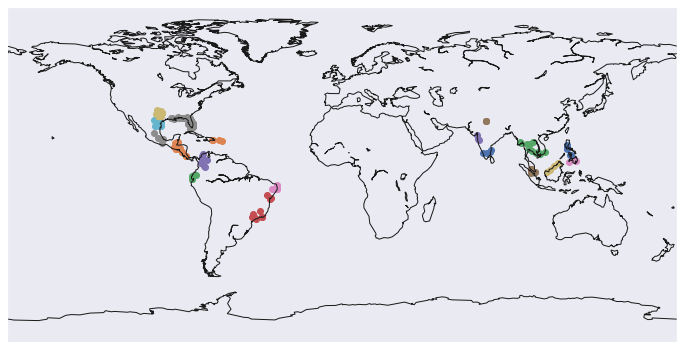

In [162]:
def count_zika_mentions(headlines):
    zika_regex = re.compile(r'\bzika\b',
                            flags=re.IGNORECASE)
    zika_count = 0
    for headline in headlines:
        if zika_regex.search(headline):
            zika_count += 1

    return zika_count

fig = plt.figure(figsize=(12, 10))
map_plotter = Basemap()

for _, group in sorted_groups + us_sorted_groups:
    headlines = group.Headline.values
    zika_count = count_zika_mentions(headlines)
    if float(zika_count) / len(headlines) > 0.5:
        map_plotter.scatter(group.Longitude.values,
                            group.Latitude.values,
                            latlon=True)
map_plotter.drawcoastlines()
plt.show()